In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import glob
import torch.optim as optim
import time

import cv2
%matplotlib inline

In [2]:
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)

In [3]:
data_dir = 'EuroSAT/'
print(os.listdir(data_dir))

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'label_map.json', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake', 'test.csv', 'train.csv', 'validation.csv']


In [4]:
d = "cpu"
if torch.cuda.is_available():
    d = "cuda:0"
device = torch.device(d)

print("Device: {}".format(device))

Device: cuda:0


In [5]:
class CustomDataset(Dataset):
    def __init__(self,path,image_size):
        self.imgs_path = path
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("\\")[-1]
            for img_path in glob.glob(class_path + "/*.jpg"):
                self.data.append([img_path, class_name])
        self.class_map = {"AnnualCrop" : 0, "Forest": 1,"HerbaceousVegetation": 2,"Highway": 3,"Industrial":4,"Pasture":5,"PermanentCrop":6,"Residential":7,"River":8,"SeaLake":9}
        self.img_dim = image_size
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        transform = transforms.Compose([transforms.ToTensor()])
        img_tensor = transform(img)
        mean, std, var = torch.mean(img_tensor), torch.std(img_tensor), torch.var(img_tensor)
        img_tensor = (img_tensor-mean)/std
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

In [6]:
from torch.utils.data.sampler import SubsetRandomSampler

def load_data(path, test_split, val_split, batch_size, input_size, shuffle_dataset=True,random_seed=42):
    dataset = CustomDataset(path,input_size)	
    # Creating data indices for training and test splits:
    dataset_size = len(dataset)
    train_test_indices = list(range(dataset_size))
    test_split = int(np.floor(test_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(train_test_indices)
    train_indices, test_indices = train_test_indices[test_split:], train_test_indices[:test_split]


   # Creating data indices for training and validation splits:
   
    train_data_size=len(train_indices)
    train_val_indices = list(range(train_data_size))
    val_split = int(np.floor(val_split * train_data_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(train_val_indices)
    train_indices, val_indices = train_val_indices[val_split:], train_val_indices[:val_split]



    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    data_loader_train = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                              sampler=train_sampler)
    data_loader_test = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=test_sampler)

    data_loader_val = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=val_sampler)


   
    print(len(data_loader_train),len(data_loader_test),len(data_loader_val))
    
    return data_loader_train, data_loader_test, data_loader_val

In [7]:
data_loader_train, data_loader_test, data_loader_val=load_data(data_dir,.2,.2,32,(64,64))


540 169 135


In [8]:
def plot_data_loader(data_loader, gridDims):
    
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = next(dataiter)
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


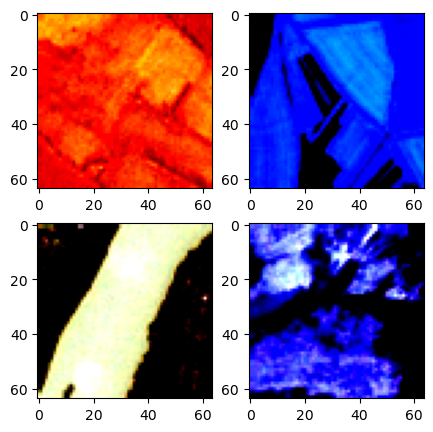

In [9]:
plot_data_loader(data_loader_test,[2,2])

In [10]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', weights=None)

Using cache found in C:\Users\solan/.cache\torch\hub\pytorch_vision_v0.10.0


In [11]:
optimizer = optim.Adam(model.parameters(),lr=0.001);
criterion = nn.CrossEntropyLoss()


In [12]:
model.to(device)

num_epochs = 20
total_steps = len(data_loader_train)
t1 = time.time()
accuracies = []
losses = []
accuracies_v = []
losses_v = []

for epoch in range(num_epochs):
    ti = 0;
    total_correct = 0;
    tl = 0.0
    for i, data in enumerate(data_loader_train):
        images, labels = data[0].to(device), data[1].to(device)
        labels=torch.flatten(labels)
        outputs = model(images)
        loss = criterion(outputs, labels)
        tl+=loss.item()
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        ti+=total
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        total_correct+= (predicted == labels).sum()

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_steps, 
                          loss.item(),
                      (correct / total) * 100))
    # validation 
    total_correct_v = 0.0
    ti_v = 0
    tl_v = 0.0
    for _, data_v in enumerate(data_loader_val):
        images_v, labels_v = data_v[0].to(device), data_v[1].to(device)
        labels_v=torch.flatten(labels_v)
        outputs_v = model(images_v)
        loss_v = criterion(outputs_v,labels_v)
#         tl_v+=loss_v.item()
        valid_loss = loss_v.item() * images_v.size(0)
        tl_v+=valid_loss
        # Validation accuracy
        total_v = labels_v.size(0)
        ti_v+=total_v
        _,predicted_v = torch.max(outputs_v.data, 1)
        correct_v = (predicted_v == labels_v).sum().item() 
        total_correct_v+= (predicted_v == labels_v).sum() 
    print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, float(tl_v)/ti_v, total_correct_v / ti_v*100.0))
    accuracies_v.append(total_correct_v / ti_v*100.0)    
    losses_v.append(float(tl_v)/ti_v)  
    accuracies.append(total_correct/ti*100.0)
    losses.append(float(tl)/ti)
           
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Epoch [1/20], Step [100/540], Train Loss: 2.0389, Train Accuracy: 12.50%
Epoch [1/20], Step [200/540], Train Loss: 2.0128, Train Accuracy: 21.88%
Epoch [1/20], Step [300/540], Train Loss: 2.0451, Train Accuracy: 21.88%
Epoch [1/20], Step [400/540], Train Loss: 2.1227, Train Accuracy: 6.25%
Epoch [1/20], Step [500/540], Train Loss: 2.1859, Train Accuracy: 9.38%
Epoch [1/20], Validation Loss: 2.1179, Validation Accuracy: 13.87%
Epoch [2/20], Step [100/540], Train Loss: 2.0526, Train Accuracy: 25.00%
Epoch [2/20], Step [200/540], Train Loss: 2.0496, Train Accuracy: 9.38%
Epoch [2/20], Step [300/540], Train Loss: 2.0963, Train Accuracy: 6.25%
Epoch [2/20], Step [400/540], Train Loss: 2.0949, Train Accuracy: 12.50%
Epoch [2/20], Step [500/540], Train Loss: 2.0860, Train Accuracy: 12.50%
Epoch [2/20], Validation Loss: 2.0987, Validation Accuracy: 14.24%
Epoch [3/20], Step [100/540], Train Loss: 2.0873, Train Accuracy: 15.62%
Epoch [3/20], Step [200/540], Train Loss: 2.0598, Train Accuracy: 6

Epoch [20/20], Step [100/540], Train Loss: 2.0564, Train Accuracy: 18.75%
Epoch [20/20], Step [200/540], Train Loss: 2.0705, Train Accuracy: 6.25%
Epoch [20/20], Step [300/540], Train Loss: 2.1020, Train Accuracy: 9.38%
Epoch [20/20], Step [400/540], Train Loss: 2.0756, Train Accuracy: 15.62%
Epoch [20/20], Step [500/540], Train Loss: 2.0626, Train Accuracy: 18.75%
Epoch [20/20], Validation Loss: 2.0973, Validation Accuracy: 13.75%
######## Training Finished in 4319.978120326996 seconds ###########


In [17]:
torch.save(model.state_dict(), "eurosat-vgg.pt")

In [15]:
#TSNE
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()
targets_list = []
outputs_list = []

with torch.no_grad():
    for idx, (inputs, targets) in enumerate(data_loader_train):
        inputs = inputs.to(device)
        targets = targets.to(device)
        targets_np = targets.data.cpu().numpy()

        outputs = model(inputs)
        outputs_np = outputs.data.cpu().numpy()

        targets_list.append(targets_np)
        outputs_list.append(outputs_np)

targets = np.concatenate(targets_list, axis=0)
outputs = np.concatenate(outputs_list, axis=0).astype(np.float64)

generating t-SNE plot...


C:\Users\solan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\solan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\solan\AppData\Local\Temp\ipykernel_6320\3168016508.py:15: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.scatterplot(


done!


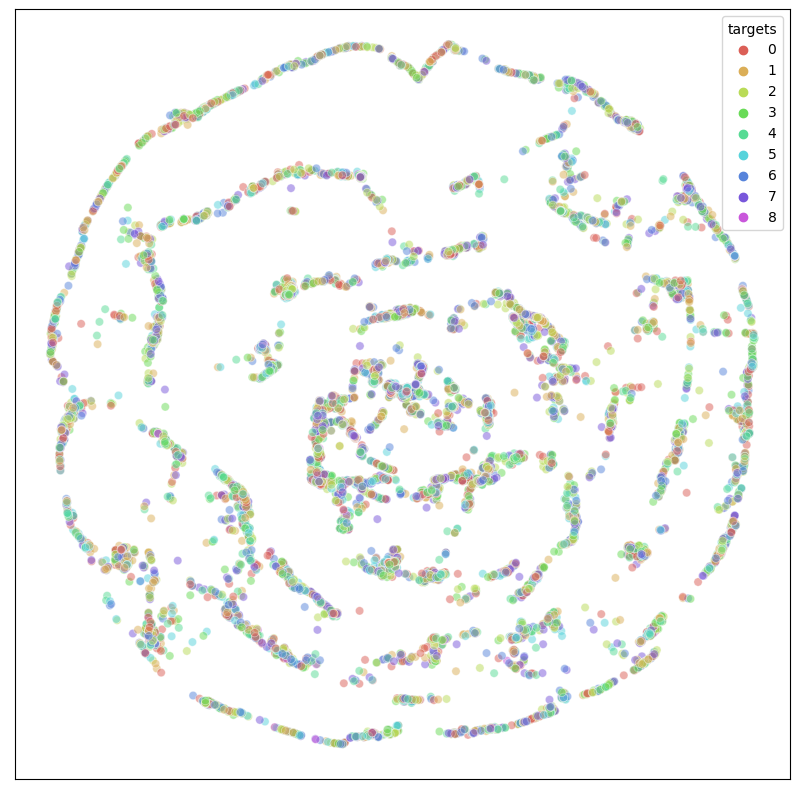

In [16]:
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
print('generating t-SNE plot...')
# tsne_output = bh_sne(outputs)
tsne = TSNE(random_state=0)
tsne_output = tsne.fit_transform(outputs)


df = pd.DataFrame(tsne_output, columns=['x', 'y'])
df['targets'] = targets

plt.rcParams['figure.figsize'] = 10, 10
sns.scatterplot(
    x='x', y='y',
    hue='targets',
    palette=sns.color_palette("hls", 10),
    data=df,
    marker='o',
    legend="full",
    alpha=0.5
)

plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')

# plt.savefig(os.path.join(save_dir,'tsne.png'), bbox_inches='tight')
print('done!')

In [18]:
model.eval() 
with torch.no_grad(): 
 correct = 0
 total = 0
 for data in data_loader_test:
  images, labels = data[0].to(device), data[1].to(device)
  labels=torch.flatten(labels)
  outputs = model(images)
  _, predicted = torch.max(outputs.data, 1)
  total += labels.size(0)
  correct += (predicted == labels).sum().item()
print('Test Accuracy of the model on the {} test images: {} %'
  .format(total, (correct / total) * 100))

Test Accuracy of the model on the 5400 test images: 11.055555555555555 %


In [19]:
acc_list = [i.item() for i in accuracies]

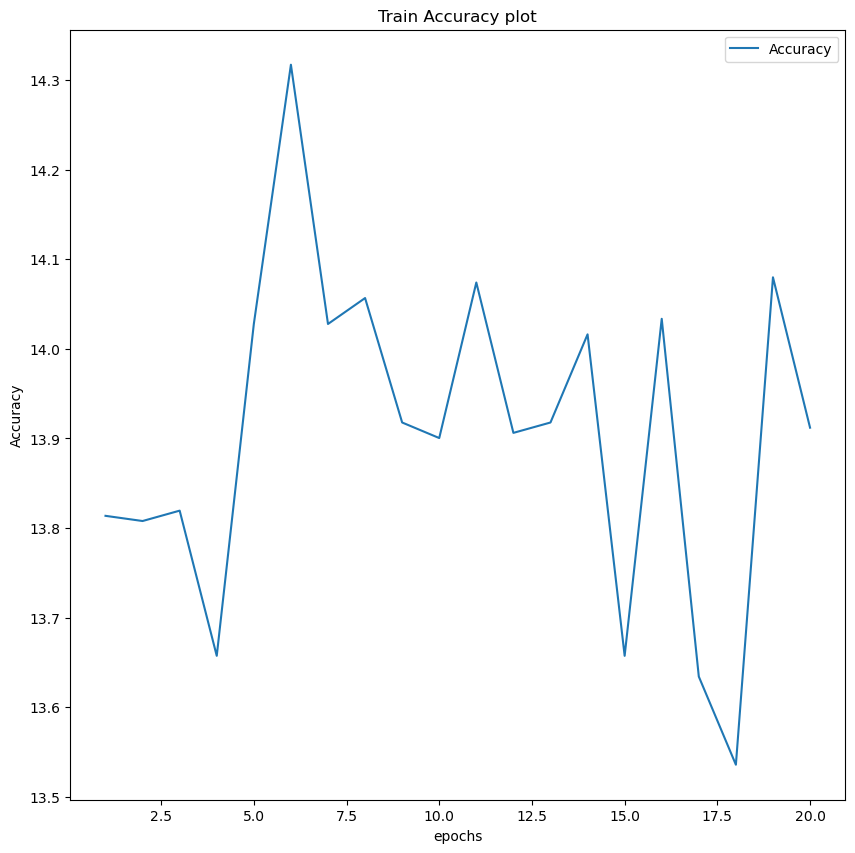

In [20]:
plt.figure()
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy plot')
plt.plot(range(1,num_epochs+1),acc_list)
plt.legend(['Accuracy'])

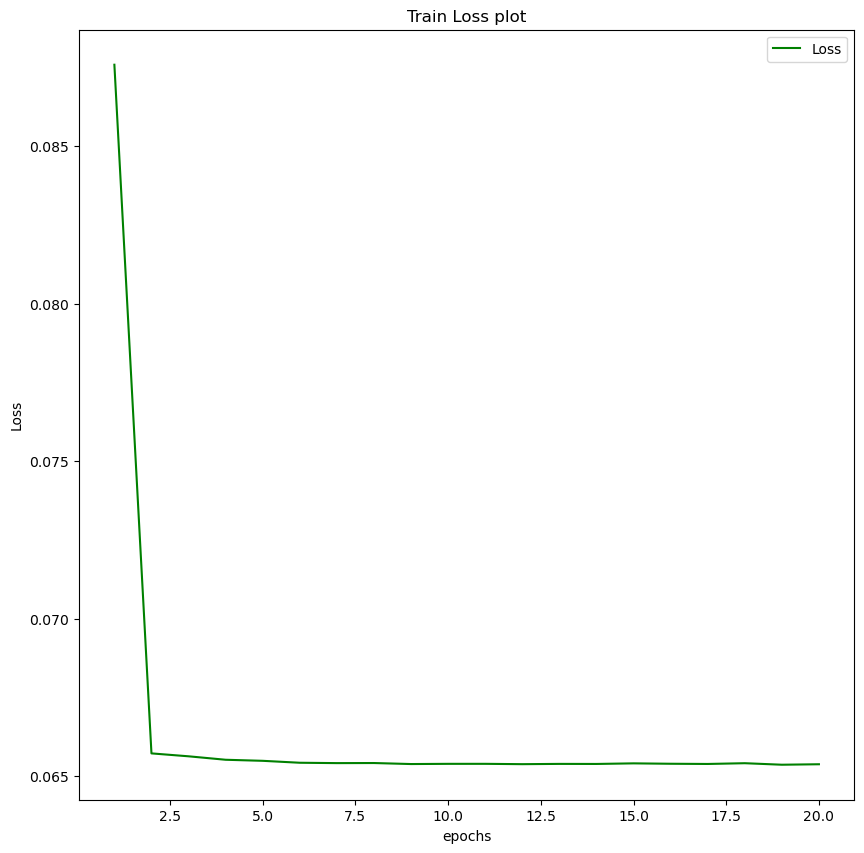

In [21]:
plt.figure()
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Train Loss plot')
plt.plot(range(1,num_epochs+1),losses,'g')
plt.legend(['Loss'])

In [22]:
acc_list_v = [i.item() for i in accuracies_v]

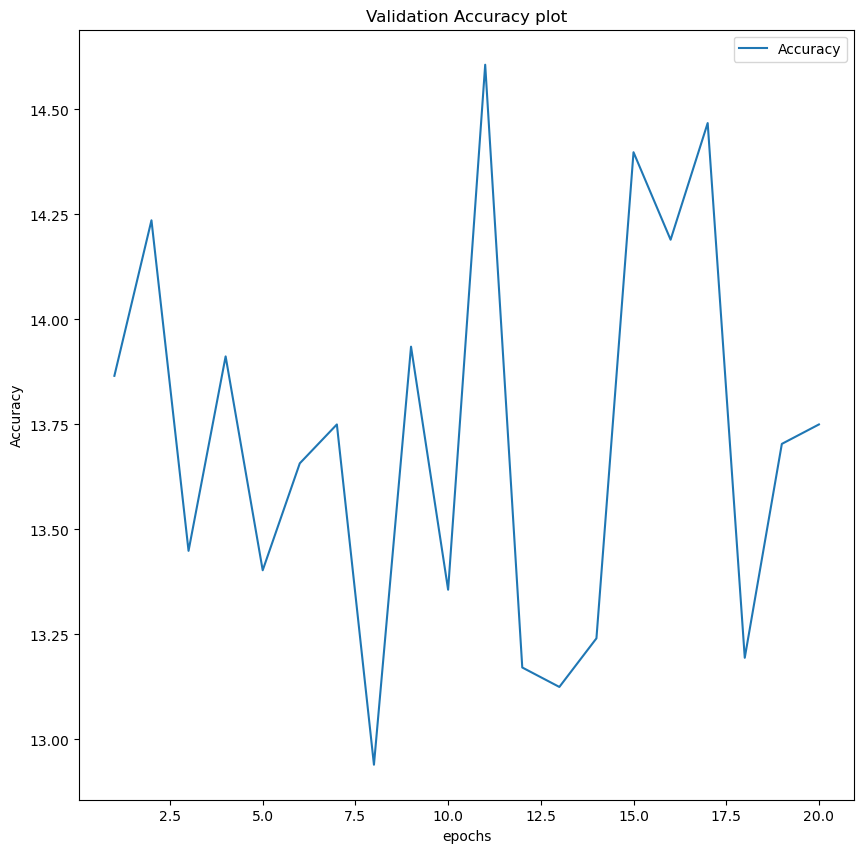

In [23]:
plt.figure()
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy plot')
plt.plot(range(1,num_epochs+1),acc_list_v)
plt.legend(['Accuracy'])

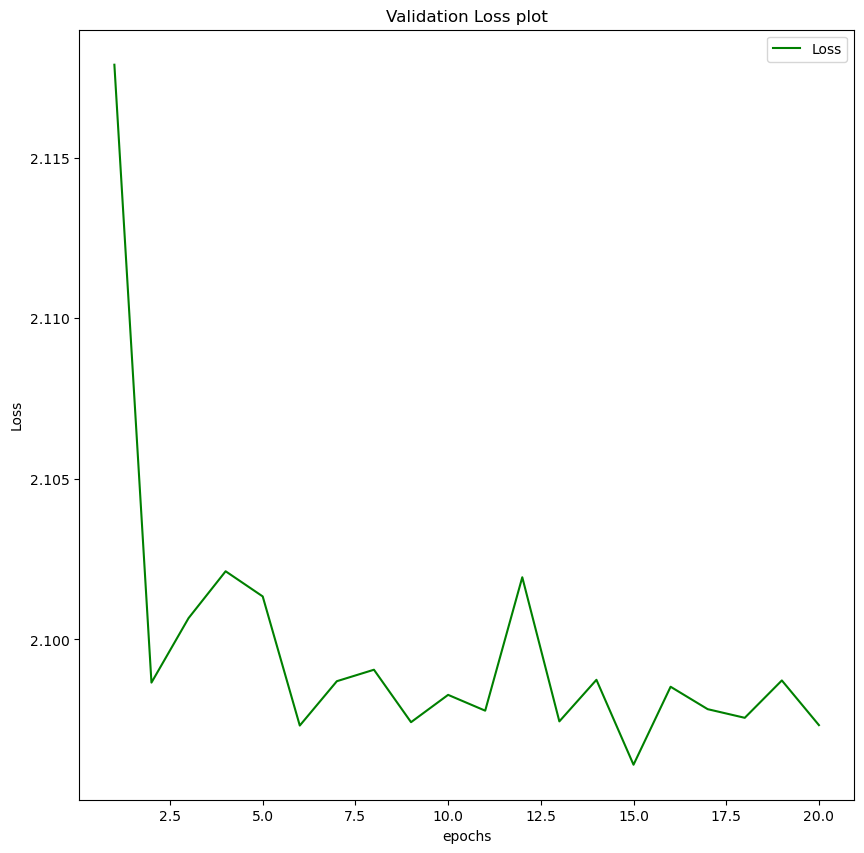

In [24]:
plt.figure()
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Validation Loss plot')
plt.plot(range(1,num_epochs+1),losses_v,'g')
plt.legend(['Loss'])

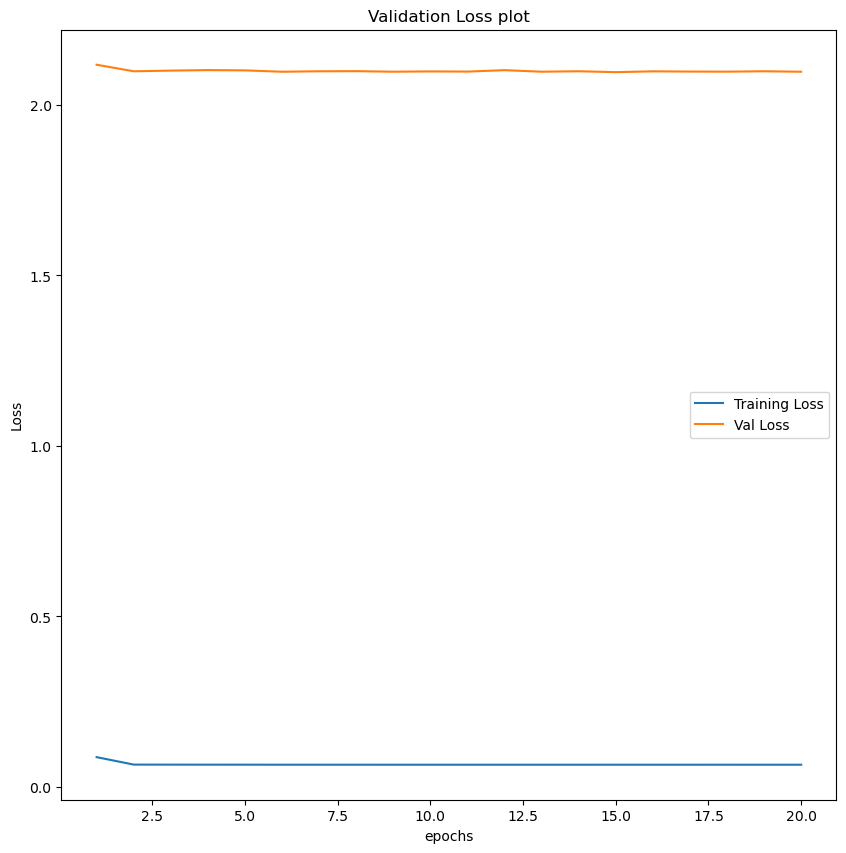

In [25]:
plt.figure()
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Validation Loss plot')

plt.plot(range(1,num_epochs+1),losses)
plt.plot(range(1,num_epochs+1),losses_v)

plt.legend(['Training Loss', 'Val Loss'])